In [30]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [31]:
# ======================= 1. Install & Import ======================
# import torch
# print("Torch version:", torch.__version__)
# print("CUDA available:", torch.cuda.is_available())
# print("CUDA device count:", torch.cuda.device_count())


In [2]:
import os
import timm
import torch
import torch.nn as nn
from torchvision import transforms
# from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import torch.multiprocessing as mp
# from dataset import Stanford40Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

# Class
from PIL import Image
from torch.utils.data import Dataset

# for report
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [3]:
# ======================= 2. Custom Dataset ========================
class Stanford40Dataset(Dataset):
    def __init__(self, img_dir, split_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        with open(split_file) as f:
            # danh sách tên ảnh (không .jpg)
            self.names = [l.strip().split(".")[0] for l in f if l.strip().split(".")[0]]
        # build list nhãn đầy đủ
        labels = sorted({self._label_from_name(n) for n in self.names})
        self.cls2idx = {c:i for i,c in enumerate(labels)}

    def _label_from_name(self, name):
        parts = name.split("_")
        return "_".join(parts[:-1])  # hoặc " ".join(parts[:-1])

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]
        img_path = os.path.join(self.img_dir, name + ".jpg")
        img = Image.open(img_path).convert("RGB")
        label_str = self._label_from_name(name)
        label = self.cls2idx[label_str]
        if self.transform:
            img = self.transform(img)
        return img, label

In [4]:
# ======================= 3. Hyperparams & Transforms ==============
NUM_CLASSES = 40
BATCH_SIZE = 16
LR = 1e-3 # Learning Rate
WD = 1e-2 # Weigth decay
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=0.4, 
        contrast=0.4, 
        saturation=0.4, 
        hue=0.1
    ),
    transforms.RandomRotation(degrees=10),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406), 
        std=(0.229, 0.224, 0.225)
    ),
    transforms.RandomErasing(
        p=0.5, 
        scale=(0.02, 0.33), 
        ratio=(0.3, 3.3), 
        value='random'
    ),
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
])

In [5]:
# ======================= 4. DataLoader ============================
DATA_ROOT = "/kaggle/input/stanford40"
train_ds = Stanford40Dataset(
    img_dir=os.path.join(DATA_ROOT, "JPEGImages"),
    split_file=os.path.join(DATA_ROOT, "ImageSplits", "train.txt"),
    transform=train_transform)
val_ds = Stanford40Dataset(
    img_dir=os.path.join(DATA_ROOT, "JPEGImages"),
    split_file=os.path.join(DATA_ROOT, "ImageSplits", "test.txt"),
    transform=val_transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(train_loader.__len__)
print(val_loader.__len__)

<bound method DataLoader.__len__ of <torch.utils.data.dataloader.DataLoader object at 0x7d6697796990>>
<bound method DataLoader.__len__ of <torch.utils.data.dataloader.DataLoader object at 0x7d6697a34510>>


In [6]:
# =============== 5. Model ===============
# model = timm.create_model("convit_base", pretrained=True)

# # Freeze toàn bộ parameters trước
# for param in model.parameters():
#     param.requires_grad = False

# # Thay classifier head
# in_features = model.head.in_features
# model.head = nn.Linear(in_features, NUM_CLASSES)

# # Head mới có requires_grad=True theo mặc định
# model = model.to(DEVICE)
model = timm.create_model("convit_base", pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Unfreeze 2 block Transformer (10, 11)
for idx in [10, 11]:
    for param in model.blocks[idx].parameters():
        param.requires_grad = True

in_features = model.head.in_features
model.head = nn.Linear(in_features, NUM_CLASSES)
model = model.to(DEVICE)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [7]:
# ======================= 6. Optimizer, Scheduler, Loss ===========
optimizer = torch.optim.SGD(model.parameters(), momentum = 0.9,
                               lr=LR, weight_decay= WD)
# cosine + 5-epoch warm-up
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
              optimizer, T_max=15,
              eta_min=1e-6)

criterion = nn.CrossEntropyLoss()


In [8]:
# ======================= 7. Training Loop ========================
train_losses = []
val_losses   = []
val_accs     = []

NUM_EPOCHS = 15 # try 30 epoch when freeze head

best_acc = 0.0
for epoch in range(1, NUM_EPOCHS + 1):
    # ======== Training ========
    model.train()
    running_train_loss = 0.0
    num_train_samples = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [Train]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        running_train_loss += loss.item() * batch_size
        num_train_samples += batch_size

    avg_train_loss = running_train_loss / num_train_samples
    train_losses.append(avg_train_loss)
    scheduler.step()

    # ======== Validation ========
    model.eval()
    running_val_loss = 0.0
    num_val_samples = 0
    correct = 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [ Val ]"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            batch_size = imgs.size(0)
            running_val_loss += loss.item() * batch_size
            num_val_samples += batch_size

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    avg_val_loss = running_val_loss / num_val_samples
    val_losses.append(avg_val_loss)

    acc = correct / num_val_samples
    val_accs.append(acc)

    print(
        f"Epoch {epoch}/{NUM_EPOCHS} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Val Acc: {acc*100:.2f}%"
    )

    # ======== Save best ========
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_convit_stanford40.pth")

print(f"Best Val Acc only head: {best_acc*100:.2f}%")

Epoch 1/15 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.66it/s]


Epoch 1/15 | Train Loss: 2.2895 | Val Loss: 1.0164 | Val Acc: 78.51%


Epoch 2/15 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.66it/s]


Epoch 2/15 | Train Loss: 1.0016 | Val Loss: 0.6681 | Val Acc: 82.81%


Epoch 3/15 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.67it/s]


Epoch 3/15 | Train Loss: 0.7682 | Val Loss: 0.5526 | Val Acc: 84.74%


Epoch 4/15 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.66it/s]


Epoch 4/15 | Train Loss: 0.6690 | Val Loss: 0.5232 | Val Acc: 84.91%


Epoch 5/15 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.60it/s]


Epoch 5/15 | Train Loss: 0.6137 | Val Loss: 0.4919 | Val Acc: 85.59%


Epoch 6/15 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.67it/s]


Epoch 6/15 | Train Loss: 0.5319 | Val Loss: 0.4677 | Val Acc: 86.51%


Epoch 7/15 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.65it/s]


Epoch 7/15 | Train Loss: 0.4867 | Val Loss: 0.4500 | Val Acc: 86.86%


Epoch 8/15 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.66it/s]


Epoch 8/15 | Train Loss: 0.4806 | Val Loss: 0.4522 | Val Acc: 86.51%


Epoch 9/15 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.66it/s]


Epoch 9/15 | Train Loss: 0.4361 | Val Loss: 0.4386 | Val Acc: 86.75%


Epoch 10/15 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.67it/s]


Epoch 10/15 | Train Loss: 0.4557 | Val Loss: 0.4406 | Val Acc: 86.97%


Epoch 11/15 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.67it/s]


Epoch 11/15 | Train Loss: 0.4248 | Val Loss: 0.4350 | Val Acc: 86.82%


Epoch 12/15 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.67it/s]


Epoch 12/15 | Train Loss: 0.4158 | Val Loss: 0.4290 | Val Acc: 87.08%


Epoch 13/15 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.67it/s]


Epoch 13/15 | Train Loss: 0.3863 | Val Loss: 0.4241 | Val Acc: 87.29%


Epoch 14/15 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.67it/s]


Epoch 14/15 | Train Loss: 0.3814 | Val Loss: 0.4261 | Val Acc: 87.11%


Epoch 15/15 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.66it/s]

Epoch 15/15 | Train Loss: 0.3866 | Val Loss: 0.4261 | Val Acc: 87.08%
Best Val Acc only head: 87.29%


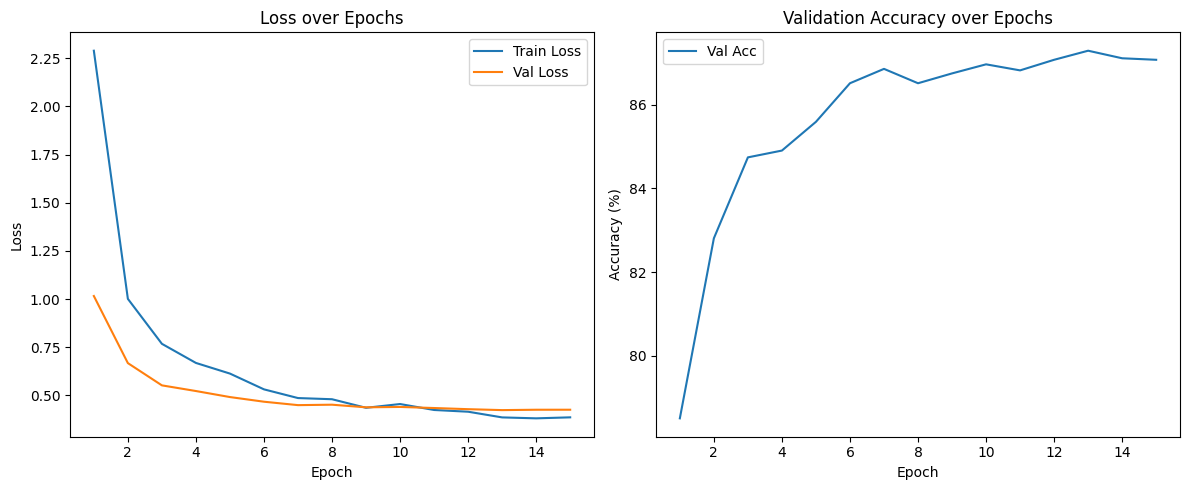

In [9]:
# ======================= 8. Loss and Accuracy ========================
epochs = np.arange(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, np.array(val_accs)*100, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

Final Eval [Val]: 100%|██████████| 346/346 [00:44<00:00,  7.71it/s]


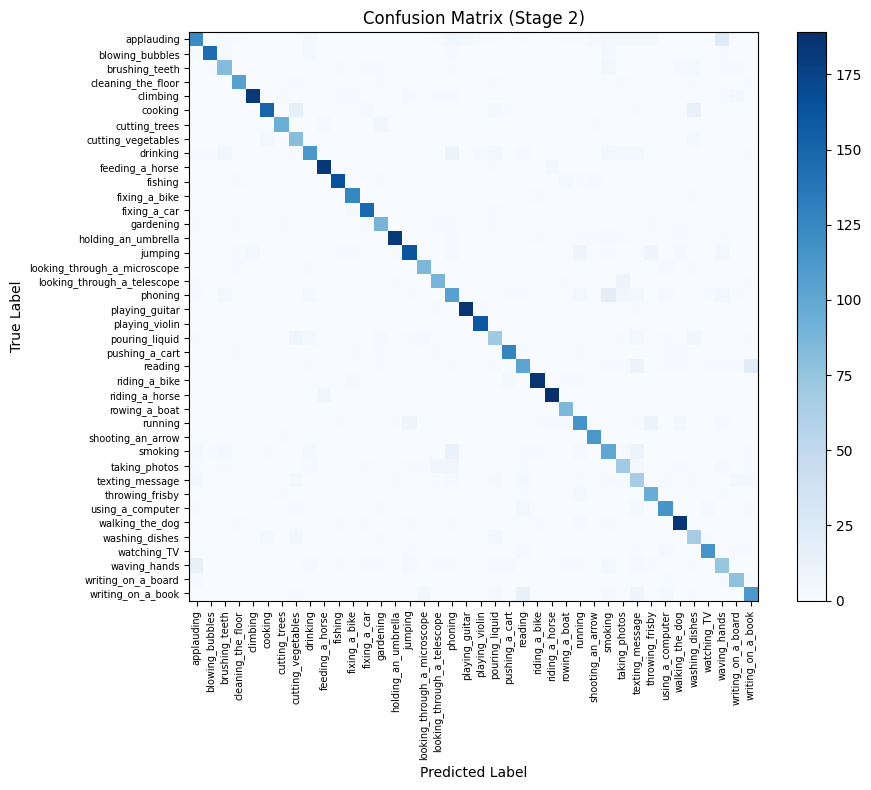

=== Classification Report ===
                              precision    recall  f1-score   support

                  applauding     0.7987    0.6685    0.7278       184
             blowing_bubbles     0.9797    0.9119    0.9446       159
              brushing_teeth     0.8119    0.8200    0.8159       100
          cleaning_the_floor     0.9381    0.9464    0.9422       112
                    climbing     0.9838    0.9333    0.9579       195
                     cooking     0.9379    0.8032    0.8653       188
               cutting_trees     0.9592    0.9126    0.9353       103
          cutting_vegetables     0.6923    0.9101    0.7864        89
                    drinking     0.8309    0.7244    0.7740       156
             feeding_a_horse     0.9531    0.9786    0.9657       187
                     fishing     0.9649    0.9538    0.9593       173
               fixing_a_bike     0.9474    0.9844    0.9655       128
                fixing_a_car     0.9548    0.9801    0.9673

In [11]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import average_precision_score
# ======== 9. Confusion Matrix and Classification report ========
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Final Eval [Val]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

classes = [c for c, idx in sorted(train_ds.cls2idx.items(), key=lambda x: x[1])]

cm = confusion_matrix(all_labels, all_preds)

# Draw heatmap confusion matrix with matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Stage 2)")
plt.colorbar()
tick_marks = np.arange(NUM_CLASSES)

plt.xticks(tick_marks, classes, rotation=90, fontsize=7)
plt.yticks(tick_marks, classes, fontsize=7)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# 2) Classification report
# Cần list tên các class (40 labels) theo đúng thứ tự cls2idx
report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
print("=== Classification Report ===")
print(report)

In [12]:
# === 9.1. TOP-5 maximum value in confusion matrix ===

# cm : numpy array (40, 40)
# create list tuple (count, true_idx, pred_idx)
flat_cm = [
    (int(cm[i, j]), i, j)
    for i in range(cm.shape[0])
    for j in range(cm.shape[1]) if (i != j)
]

# sort decs
flat_cm.sort(key=lambda x: x[0], reverse=True)

print("=== Top 20 values in Confusion Matrix ===")
for count, i, j in flat_cm[:20]:
    print(f"Count={count:4d} | True = '{classes[i]:<20}' | Pred = '{classes[j]:<20}'")
# Eg: Count= 123 | True = 'walking            ' | Pred = 'walking            '

=== Top 20 values in Confusion Matrix ===
Count=  23 | True = 'applauding          ' | Pred = 'waving_hands        '
Count=  21 | True = 'reading             ' | Pred = 'writing_on_a_book   '
Count=  19 | True = 'phoning             ' | Pred = 'smoking             '
Count=  16 | True = 'cooking             ' | Pred = 'cutting_vegetables  '
Count=  14 | True = 'cooking             ' | Pred = 'washing_dishes      '
Count=  14 | True = 'waving_hands        ' | Pred = 'applauding          '
Count=  14 | True = 'writing_on_a_book   ' | Pred = 'reading             '
Count=  13 | True = 'smoking             ' | Pred = 'phoning             '
Count=  12 | True = 'running             ' | Pred = 'throwing_frisby     '
Count=  11 | True = 'looking_through_a_telescope' | Pred = 'taking_photos       '
Count=  11 | True = 'reading             ' | Pred = 'texting_message     '
Count=  10 | True = 'drinking            ' | Pred = 'phoning             '
Count=  10 | True = 'smoking             ' | Pred =

In [13]:
# === 9.2. F1-score for all class and print top10 highest / lowest ===

# precision, recall, f1_scores, support
precision, recall, f1_scores, support = precision_recall_fscore_support(
    all_labels, 
    all_preds,
    labels=range(len(classes)),
    zero_division=0  
)

# list tuple (f1, class_idx)
f1_with_idx = [(f1_scores[i], i) for i in range(len(classes))]

# Top-10 F1 highest
f1_with_idx.sort(key=lambda x: x[0], reverse=True)
print("\n=== Top 10 highest F1-scores ===")
for f1, idx in f1_with_idx[:10]:
    print(f"Class = '{classes[idx]:<20}' | F1 = {f1:.4f}")



=== Top 10 highest F1-scores ===
Class = 'playing_violin      ' | F1 = 0.9877
Class = 'playing_guitar      ' | F1 = 0.9815
Class = 'shooting_an_arrow   ' | F1 = 0.9700
Class = 'fixing_a_car        ' | F1 = 0.9673
Class = 'riding_a_horse      ' | F1 = 0.9668
Class = 'riding_a_bike       ' | F1 = 0.9661
Class = 'feeding_a_horse     ' | F1 = 0.9657
Class = 'fixing_a_bike       ' | F1 = 0.9655
Class = 'holding_an_umbrella ' | F1 = 0.9630
Class = 'fishing             ' | F1 = 0.9593


In [14]:
# Top-10 F1 lowest
f1_with_idx.sort(key=lambda x: x[0]) 
print("\n=== Top 10 lowest F1-scores ===")
for f1, idx in f1_with_idx[:10]:
    print(f"Class = '{classes[idx]:<20}' | F1 = {f1:.4f}")


=== Top 10 lowest F1-scores ===
Class = 'texting_message     ' | F1 = 0.6047
Class = 'waving_hands        ' | F1 = 0.6491
Class = 'phoning             ' | F1 = 0.6667
Class = 'smoking             ' | F1 = 0.6897
Class = 'taking_photos       ' | F1 = 0.7005
Class = 'pouring_liquid      ' | F1 = 0.7179
Class = 'applauding          ' | F1 = 0.7278
Class = 'washing_dishes      ' | F1 = 0.7293
Class = 'reading             ' | F1 = 0.7312
Class = 'writing_on_a_book   ' | F1 = 0.7645


In [15]:
all_with_idx = [(precision[i], recall[i], f1_scores[i], support[i], i) for i in range(len(classes))]
all_with_idx.sort(key=lambda x: x[2]) 
for pre, rec, f1, sup, idx in all_with_idx[:10]:
    print(f"Class = '{classes[idx]:<20}' | precision = {pre:.4f} | recall = {rec:.4f} | F1 = {f1:.4f} | support = {sup}")

Class = 'texting_message     ' | precision = 0.5328 | recall = 0.6989 | F1 = 0.6047 | support = 93
Class = 'waving_hands        ' | precision = 0.6271 | recall = 0.6727 | F1 = 0.6491 | support = 110
Class = 'phoning             ' | precision = 0.6731 | recall = 0.6604 | F1 = 0.6667 | support = 159
Class = 'smoking             ' | precision = 0.6711 | recall = 0.7092 | F1 = 0.6897 | support = 141
Class = 'taking_photos       ' | precision = 0.6900 | recall = 0.7113 | F1 = 0.7005 | support = 97
Class = 'pouring_liquid      ' | precision = 0.7368 | recall = 0.7000 | F1 = 0.7179 | support = 100
Class = 'applauding          ' | precision = 0.7987 | recall = 0.6685 | F1 = 0.7278 | support = 184
Class = 'washing_dishes      ' | precision = 0.6667 | recall = 0.8049 | F1 = 0.7293 | support = 82
Class = 'reading             ' | precision = 0.7612 | recall = 0.7034 | F1 = 0.7312 | support = 145
Class = 'writing_on_a_book   ' | precision = 0.7619 | recall = 0.7671 | F1 = 0.7645 | support = 146


In [16]:
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)                 # logits shape (B,40)
        probs = torch.softmax(outputs, 1).cpu().numpy()  # (B,40)
        all_probs.append(probs)
        all_labels.append(labels.numpy())

# Ghép lại thành (N,40) và (N,)
all_probs = np.concatenate(all_probs, axis=0)   # (N,40)
all_labels = np.concatenate(all_labels, axis=0) # (N,)

# Tạo mat nhãn one-hot (N,40)
N, C = all_probs.shape
y_true_mat = np.zeros((N, C), dtype=np.int32)
y_true_mat[np.arange(N), all_labels] = 1

# Tính AP cho từng lớp
APs = np.zeros(C, dtype=np.float32)
for c in range(C):
    APs[c] = average_precision_score(y_true_mat[:, c], all_probs[:, c])

mAP = APs.mean()
print("=> mAP = {:.2f}%".format(mAP * 100.0))

=> mAP = 92.15%


# Unfreeze more block on backbone  

In [28]:
# ======================= 1. Load model + head-only checkpoint (stage 1) ========================
# model = timm.create_model("convit_base", pretrained=False)
# in_features = model.head.in_features
# model.head = nn.Linear(in_features, NUM_CLASSES)
# model = model.to(DEVICE)

# CHECKPOINT_PATH = "/kaggle/working/best_convit_stanford40.pth"
# checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
# model.load_state_dict(checkpoint)
# print("Loaded checkpoint.")


model = timm.create_model("convit_base", pretrained=True)

for param in model.parameters():
    param.requires_grad = False

in_features = model.head.in_features
model.head = nn.Linear(in_features, NUM_CLASSES)
model = model.to(DEVICE)

# ======================= 2. Unfreeze 4 block backbone (stage 2) ========================
for idx in [8, 11]:
    for param in model.blocks[idx].parameters():
        param.requires_grad = True

for param in model.head.parameters():
    param.requires_grad = True

# ======================= 3. Optimizer, Scheduler, Criterion ========================
LR = 2e-4
WEIGHT_DECAY = 6e-2
TOTAL_EPOCHS = 30
STAGE1_EPOCHS = NUM_EPOCHS
STAGE2_EPOCHS = TOTAL_EPOCHS - STAGE1_EPOCHS  # = 15

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=STAGE2_EPOCHS, eta_min=1e-6)
criterion = nn.CrossEntropyLoss()


In [29]:
# ======================= 4. Stage 2 Training Loop + Save metrics ========================
train_losses = []
val_losses   = []
val_accs     = []

best_acc = 0.0
patience = 5
epochs_no_improve = 0

for epoch2 in range(1, STAGE2_EPOCHS + 1):
    epoch = STAGE1_EPOCHS + epoch2
    model.train()
    running_train_loss = 0.0
    total_train = 0

    for imgs, labels in tqdm(train_loader, desc=f"[Stage2] Epoch {epoch}/{TOTAL_EPOCHS} [Train]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        bs = imgs.size(0)
        running_train_loss += loss.item() * bs
        total_train += bs

    avg_train_loss = running_train_loss / total_train
    train_losses.append(avg_train_loss)
    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0.0
    total_val = 0
    correct = 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"[Stage2] Epoch {epoch}/{TOTAL_EPOCHS} [ Val ]"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            bs = imgs.size(0)
            running_val_loss += loss.item() * bs
            total_val += bs

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    avg_val_loss = running_val_loss / total_val
    val_losses.append(avg_val_loss)

    val_acc = correct / total_val
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch}/{TOTAL_EPOCHS} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Val Acc: {val_acc*100:.2f}% | "
        f"LR: {scheduler.get_last_lr()[0]:.6f}"
    )

    # Early stopping & lưu model tốt nhất
    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_convit_stage2.pth")
        print(f"  → Saved new best model at epoch {epoch} (Val Acc={val_acc*100:.2f}%)")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"  → No improvement for {patience} epochs → Early stopping at epoch {epoch}")
            break

print(f"Finished Stage 2. Best Val Acc: {best_acc*100:.2f}%")

[Stage2] Epoch 16/30 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.66it/s]


Epoch 16/30 | Train Loss: 1.4118 | Val Loss: 0.5529 | Val Acc: 83.55% | LR: 0.000198
  → Saved new best model at epoch 16 (Val Acc=83.55%)


[Stage2] Epoch 17/30 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.67it/s]


Epoch 17/30 | Train Loss: 0.5546 | Val Loss: 0.5195 | Val Acc: 84.40% | LR: 0.000191
  → Saved new best model at epoch 17 (Val Acc=84.40%)


[Stage2] Epoch 18/30 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.67it/s]


Epoch 18/30 | Train Loss: 0.3961 | Val Loss: 0.4335 | Val Acc: 86.77% | LR: 0.000181
  → Saved new best model at epoch 18 (Val Acc=86.77%)


[Stage2] Epoch 19/30 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.67it/s]


Epoch 19/30 | Train Loss: 0.2835 | Val Loss: 0.4332 | Val Acc: 87.26% | LR: 0.000167
  → Saved new best model at epoch 19 (Val Acc=87.26%)


[Stage2] Epoch 20/30 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.68it/s]


Epoch 20/30 | Train Loss: 0.2291 | Val Loss: 0.4349 | Val Acc: 87.58% | LR: 0.000150
  → Saved new best model at epoch 20 (Val Acc=87.58%)


[Stage2] Epoch 21/30 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.67it/s]


Epoch 21/30 | Train Loss: 0.1961 | Val Loss: 0.4412 | Val Acc: 87.60% | LR: 0.000131
  → Saved new best model at epoch 21 (Val Acc=87.60%)


[Stage2] Epoch 22/30 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.67it/s]


Epoch 22/30 | Train Loss: 0.1740 | Val Loss: 0.4068 | Val Acc: 88.39% | LR: 0.000111
  → Saved new best model at epoch 22 (Val Acc=88.39%)


[Stage2] Epoch 23/30 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.67it/s]


Epoch 23/30 | Train Loss: 0.1420 | Val Loss: 0.4467 | Val Acc: 87.51% | LR: 0.000090


[Stage2] Epoch 24/30 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.67it/s]


Epoch 24/30 | Train Loss: 0.1241 | Val Loss: 0.4090 | Val Acc: 88.39% | LR: 0.000070


[Stage2] Epoch 25/30 [ Val ]: 100%|██████████| 346/346 [00:44<00:00,  7.69it/s]


Epoch 25/30 | Train Loss: 0.1095 | Val Loss: 0.4260 | Val Acc: 87.80% | LR: 0.000051


[Stage2] Epoch 26/30 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.67it/s]


Epoch 26/30 | Train Loss: 0.0862 | Val Loss: 0.4040 | Val Acc: 88.83% | LR: 0.000034
  → Saved new best model at epoch 26 (Val Acc=88.83%)


[Stage2] Epoch 27/30 [ Val ]: 100%|██████████| 346/346 [00:44<00:00,  7.69it/s]


Epoch 27/30 | Train Loss: 0.0730 | Val Loss: 0.4075 | Val Acc: 88.61% | LR: 0.000020


[Stage2] Epoch 28/30 [ Val ]: 100%|██████████| 346/346 [00:44<00:00,  7.69it/s]


Epoch 28/30 | Train Loss: 0.0740 | Val Loss: 0.4013 | Val Acc: 88.74% | LR: 0.000010


[Stage2] Epoch 29/30 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.69it/s]


Epoch 29/30 | Train Loss: 0.0688 | Val Loss: 0.3980 | Val Acc: 88.97% | LR: 0.000003
  → Saved new best model at epoch 29 (Val Acc=88.97%)


[Stage2] Epoch 30/30 [ Val ]: 100%|██████████| 346/346 [00:45<00:00,  7.69it/s]

Epoch 30/30 | Train Loss: 0.0588 | Val Loss: 0.4001 | Val Acc: 88.94% | LR: 0.000001
Finished Stage 2. Best Val Acc: 88.97%


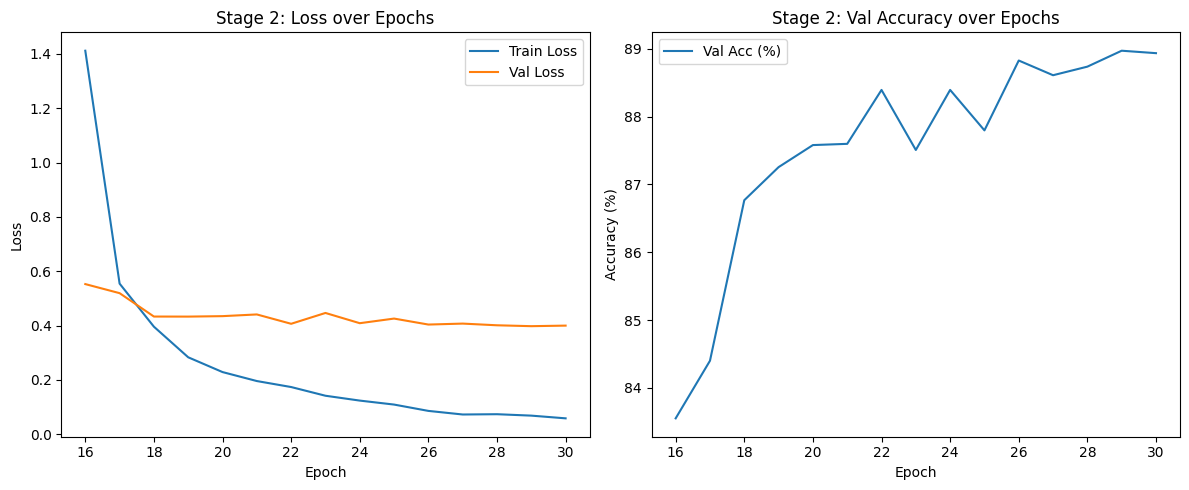

Final Eval [Val]: 100%|██████████| 346/346 [00:44<00:00,  7.71it/s]


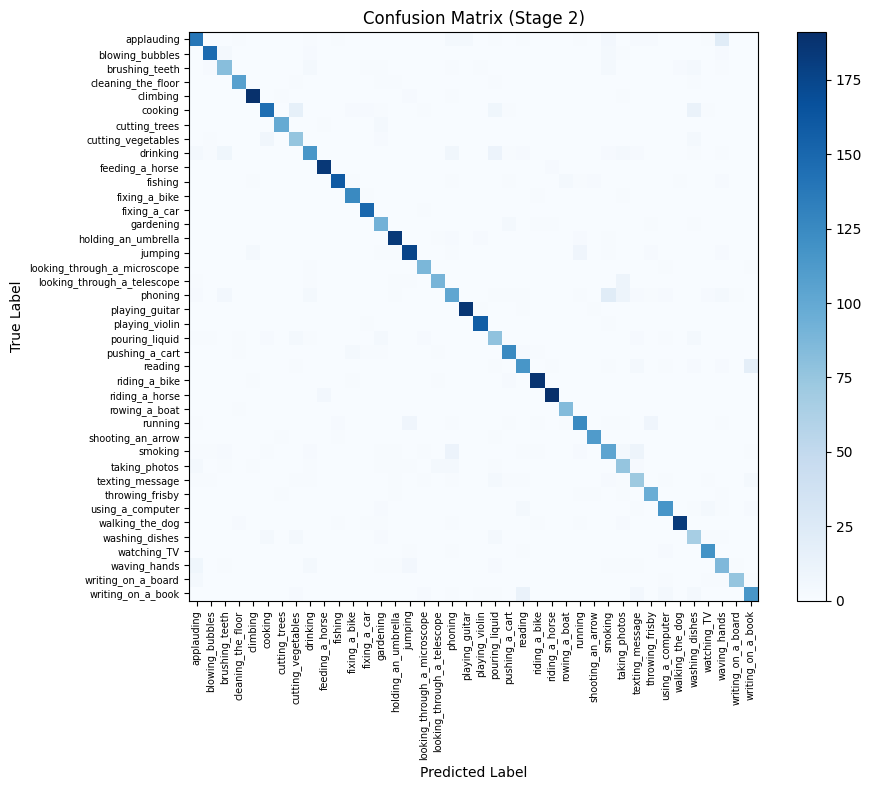

In [30]:

# ======================= 5. Loss & Accuracy ========================
epochs = np.arange(STAGE1_EPOCHS+1, STAGE1_EPOCHS + len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Train & Val Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Stage 2: Loss over Epochs")
plt.legend()

# Val Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, np.array(val_accs) * 100, label="Val Acc (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Stage 2: Val Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# ======================= 6. Confusion Matrix and heatmap ========================
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Final Eval [Val]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = confusion_matrix(all_labels, all_preds)

# Draw heatmap confusion matrix with matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Stage 2)")
plt.colorbar()
tick_marks = np.arange(NUM_CLASSES)

plt.xticks(tick_marks, classes, rotation=90, fontsize=7)
plt.yticks(tick_marks, classes, fontsize=7)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

Khi unfreeze toàn bộ mô hình, hiện tượng overfitting xảy ra trên tập huấn luyện. Do đó, tôi sẽ thử chỉ unfreeze một vài lớp cuối của khối Vision Transformer, như đề xuất trong bài báo, nhằm giúp mô hình học được đặc trưng phân bố hình ảnh liên quan đến hành động.

In [ ]:
print(model)

In [31]:
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)                 # logits shape (B,40)
        probs = torch.softmax(outputs, 1).cpu().numpy()  # (B,40)
        all_probs.append(probs)
        all_labels.append(labels.numpy())

# Ghép lại thành (N,40) và (N,)
all_probs = np.concatenate(all_probs, axis=0)   # (N,40)
all_labels = np.concatenate(all_labels, axis=0) # (N,)

# Tạo mat nhãn one-hot (N,40)
N, C = all_probs.shape
y_true_mat = np.zeros((N, C), dtype=np.int32)
y_true_mat[np.arange(N), all_labels] = 1

# Tính AP cho từng lớp
APs = np.zeros(C, dtype=np.float32)
for c in range(C):
    APs[c] = average_precision_score(y_true_mat[:, c], all_probs[:, c])

mAP = APs.mean()
print("=> mAP = {:.2f}%".format(mAP * 100.0))

=> mAP = 93.40%
